```{contents}
:local:
:depth: 2
```

# Model Validation

## Learning Objectives

By the end of this chapter, you should be able to:

1. **Compute and interpret** multiple regression accuracy metrics (e.g.\ $r^2$, MAE, RMSE) and diagnose error structure with visual tools.  
2. **Apply** hold‑out, *k*-fold, and leave‑one‑out cross‑validation to estimate generalization error and discuss their trade‑offs.  
3. **Quantify prediction uncertainty** using residual analysis, resampling (bootstrapping), and Gaussian‐process regression.  
4. **Assess assumptions** such as homoskedasticity and data representativeness, and explain how violating them impacts error estimates.  
5. **Select appropriate validation and uncertainty techniques** for chemical‑engineering data sets of varying size and noise characteristics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

## Accuracy Metrics

Choosing appropriate accuracy metrics is a crucial step in evaluating regression models: these metrics quantify how closely predictions match observed data and help compare model performance in a standardized way. Before applying these metrics to a real dataset, we will illustrate their utility using a classic toy example—Anscombe’s quartet.

Anscombe’s quartet is a demonstration introduced by statistician Francis Anscombe in 1973. It consists of four small datasets, each with 11 (x, y) pairs, that share identical summary statistics—mean of x and y, variance, correlation coefficient, and parameters of a fitted linear regression—yet exhibit strikingly different patterns when plotted. This example underscores the importance of visualizing data before relying on numerical summaries alone. Below is a scatterplot for each dataset:

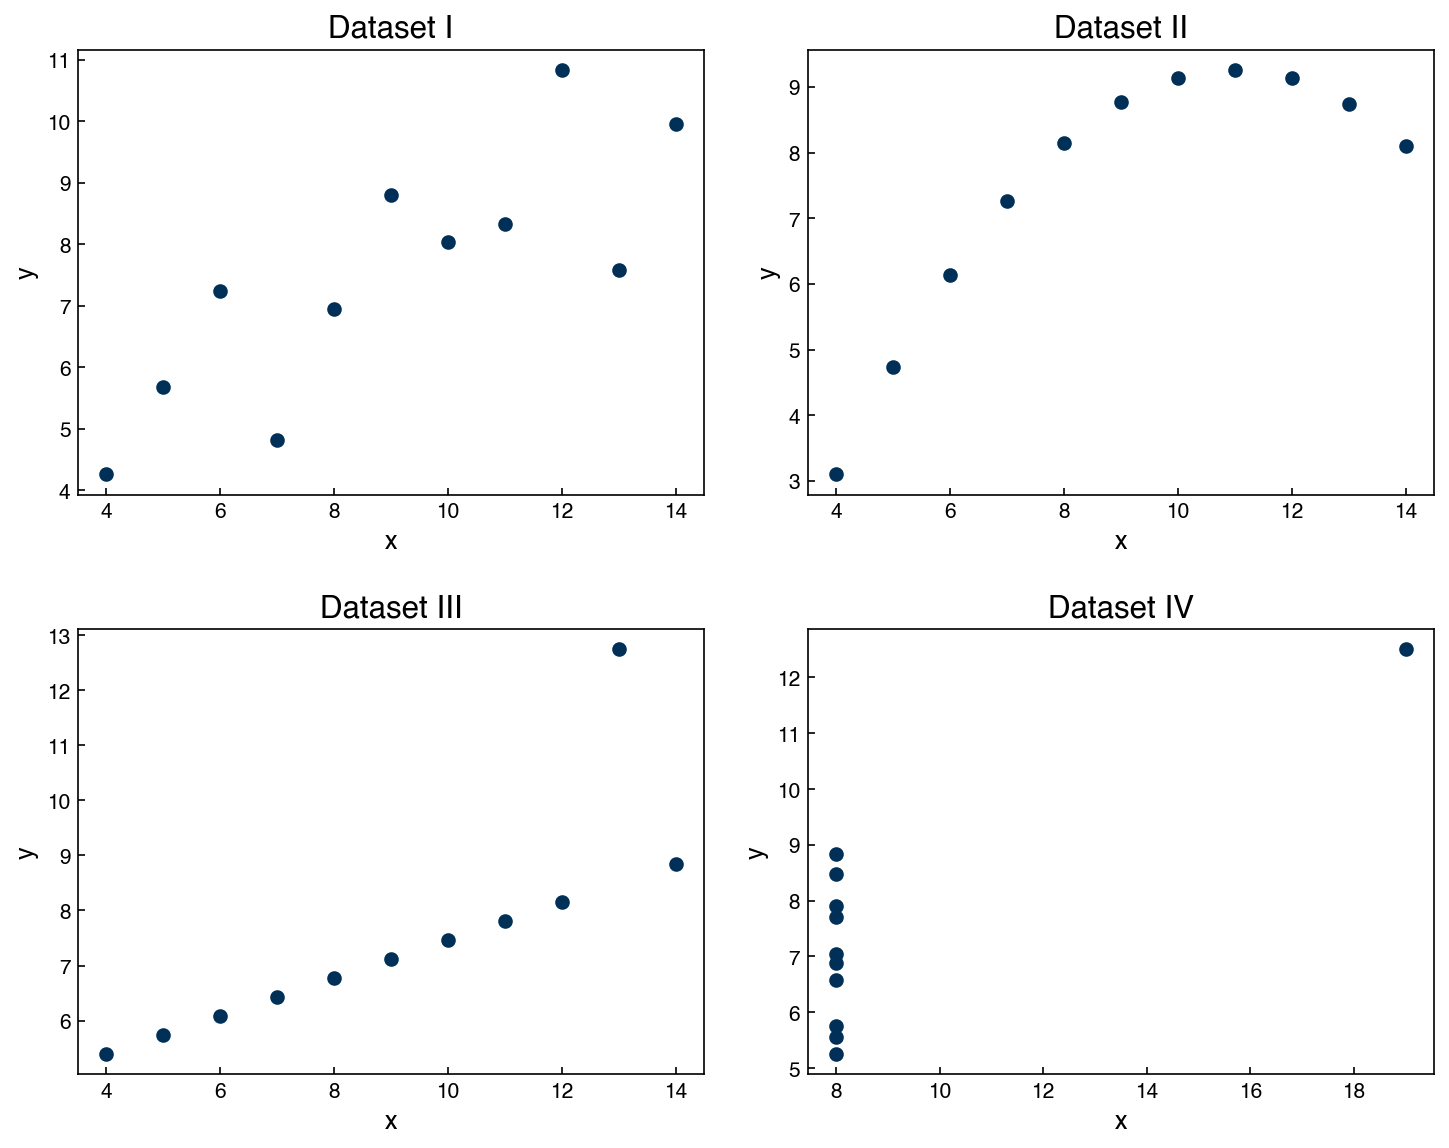

In [2]:
import numpy as np

#manually input Anscomb's quartet. The first 3 datasets share x points.
x1 = x2 = x3 = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]) 

xs = [x1, x2, x3, x4]
ys = [y1, y2, y3, y4]
labels = ['I', 'II', 'III', 'IV']


# Scatterplot for each dataset
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, label, x, y in zip(axes.flatten(), labels, xs, ys):
    ax.scatter(x, y)
    ax.set_title(f'Dataset {label}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Compute metrics for Anscombe's quartet
rows = []
for label, x, y in zip(labels, xs, ys):
    m, b = np.polyfit(x, y, 1)
    yhat = m * x + b
    rows.append({
        'Dataset': label,
        'R^2': r2_score(y, yhat),
        'MAE': mean_absolute_error(y, yhat),
        'RMSE': root_mean_squared_error(y, yhat),
        'Max Error': np.max(np.abs(y - yhat))
    })
metrics_df = pd.DataFrame(rows)
metrics_df

,Dataset,R^2,MAE,RMSE,Max Error
0,I,0.666542,0.837405,1.118550,1.921273
1,II,0.666242,0.967934,1.119102,1.900909
2,III,0.666324,0.715967,1.118286,3.241091
3,IV,0.666707,0.902727,1.117729,1.839000


```{note}
Notice that each of the four datasets yields nearly identical $r^2$ and RMSE, even though their scatterplots differ substantially. This illustrates how numerical summaries alone can mask important structural differences, and is a good reminder of the power of visualization and the need for using multiple metrics to evaluate models.
```

It is important to consider the context of a regression model and choose accuracy metrics that are relevant to its application. Below we introduce several commonly‑used options and illustrate them on Anscombe’s quartet.

### $r^2$ value

The $r^2$ metric varies from 0 to 1, with higher values corresponding to better models. It quantifies the fraction of variance in $y$ explained by the model, and $r^2$ will always increase (or stay constant) as you add more fitted parameters to the model. 


$$r^2 = 1 - \frac{\sum_i (y_i-\hat y_i)^2}{\sum_i (y_i-\bar y)^2}.$$

Conceptually, $r^2$ can be considered as a ratio between the sum-of-squares errors for the model (numerator) and the sum-of-squares errors for a "trivial" model that just always predicts the mean of the data (denominator).

```{admonition} Explanation
:class: note
A **negative $r^2$** can occur when the chosen model fits the data worse than the trivial model that always predicts the mean of $y$.  In other words, the sum‑of‑squares error of the model exceeds the total variance of the data.  This signals severe model mis‑specification or extrapolation outside the domain of validity. It is commonly encountered in cross validation, when the $r^2$ score is computed on a test or validation set that was not used to determine the parameters (and indicates that the model does not generalize beyond the training data).
```

### Mean absolute error (MAE)

MAE reports the average magnitude of errors in the original units of $y$, making it easy to interpret (“on average we miss by 0.3 bar”). Because the penalty is linear in $|y_i - \hat{y}_i|$, MAE is more robust to outliers than RMSE. As a loss, minimizing MAE corresponds to estimating the conditional median (for a constant model), so MAE emphasizes typical errors rather than occasional large ones.

$$\text{MAE} = \frac{1}{N}\sum_i |y_i-\hat y_i|.$$

### Root‑mean‑squared error (RMSE)

RMSE also has the units of $y$, but penalizes large errors more strongly due to squaring, so it is sensitive to outliers. If residuals are i.i.d. Gaussian with zero mean, RMSE is an estimate of the standard deviation of the errors and minimizing a loss function that uses RMSE aligns with maximum-likelihood estimation under that noise model. 
For the same dataset, RMSE $\geq$ MAE, with equality only when all absolute errors are equal.

$$\text{RMSE}=\sqrt{\frac{1}{N}\sum_i (y_i-\hat y_i)^2}. $$

### Error percentiles

Error percentiles give an alternative way to think about errors. If we define absolute errors $e_i = |y_i - \hat y_i|$, then the **$p$th error percentile** $Q_p$ is the value such that $p\%$ of the absolute errors are $\le Q_p$. Common choices are the **median** ($Q_{50}$, also called the *median absolute error*, MedAE), and tail summaries like $Q_{90}$, $Q_{95}$, or $Q_{99}$ to quantify “how bad things get” for the hardest cases.

Percentiles are in the same units as $y$, are easy to interpret ("90% of predictions are within 0.12 MPa"), and more robust to outliers than RMSE. They complement MAE/RMSE by separating **typical performance** (e.g., $Q_{50}$) from **tail risk** (e.g., $Q_{95}$). However, it is difficult to specifically optimize models for error percentiles, since they cannot be differentiated with standard methods.


### Maximum error

The worst‑case deviation, $\max_i |y_i-\hat y_i|$ , is useful when spec violations or safety margins matter (e.g., no prediction may err by more than 2 degrees C). It is extremely sensitive to a single outlier; practitioners often report it alongside a high quantile of the absolute error distribution (e.g., 95th percentile) to summarize tail risk more stably. Similar to percentiles, the max error is difficult to directly minimize.

### Parity plots

Plotting $y$ versus $\hat y$ gives a quick visual sense of bias (systematic over/under-prediction shifts points above/below the line) and spread (random error). Funnel shapes indicate heteroscedasticity (error grows with magnitude). Stratifying or coloring points by key features can reveal regime-dependent errors. Always pay attention to the scale of scatter plots, since they can sometimes be misleading if the range of the data is much larger than the typical errors (i.e., the errors "look small" on the scatter plot, but they may actually be large on an absolute scale).

Here we will make a parity plot for each model in Anscomb's quartet, assuming a simple linear regression model.

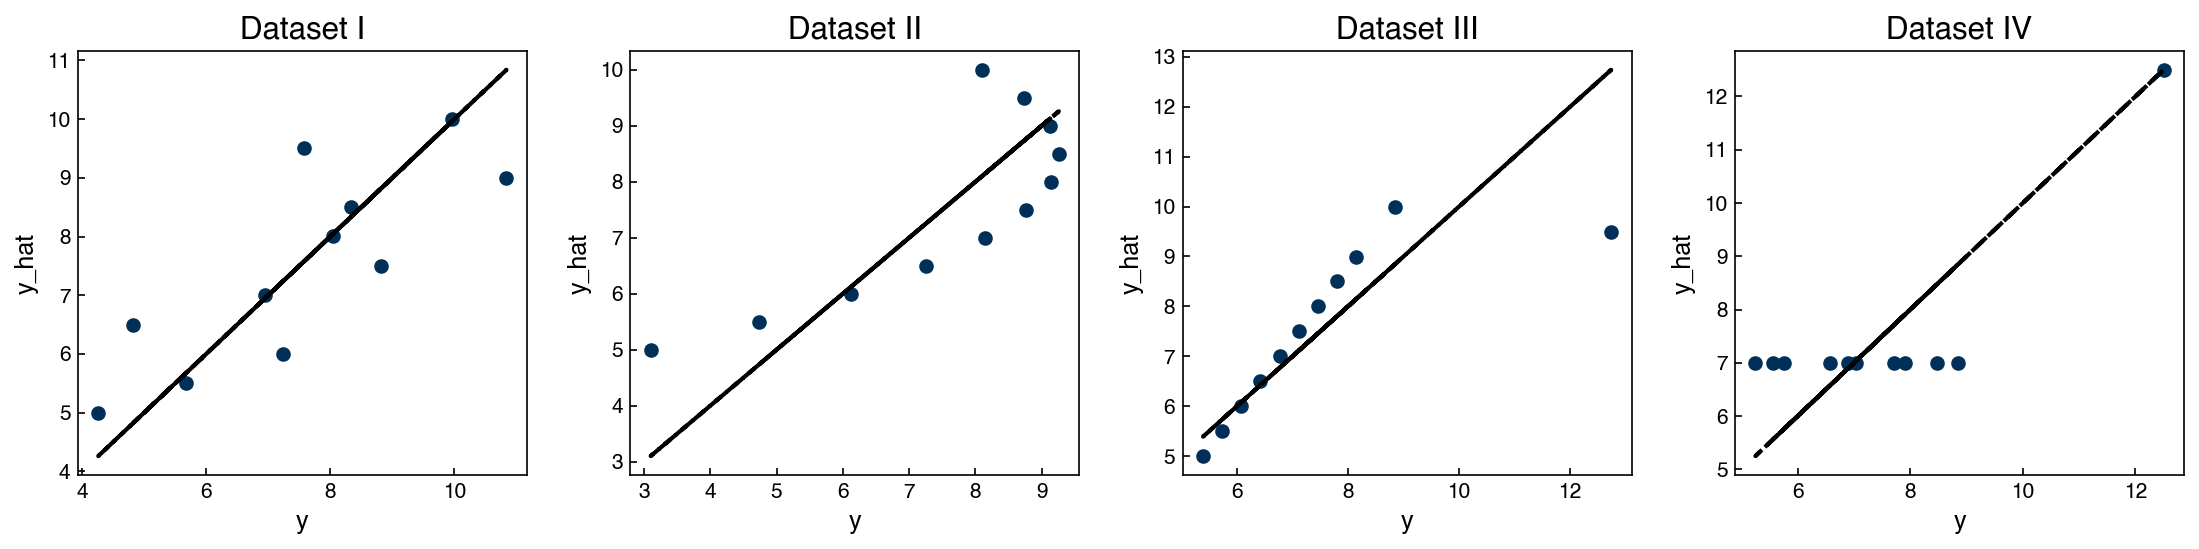

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, label, x, y in zip(axes.flatten(), labels, xs, ys):

    ax.set_title(f'Dataset {label}')
    ax.set_xlabel('y')
    ax.set_ylabel('y_hat')
    m, b = np.polyfit(x, y, deg=1)
    yhat = m*x + b

    ax.scatter(y, yhat)
    ax.plot(y, y, 'k--') #an easy way to plot the 45 degree "parity" line

plt.tight_layout();

### Error histograms

Error (residual) histograms provide another perspective on model accuracy.  Whereas summary numbers like MAE or RMSE compress all errors into a single value, a histogram reveals *shape*: skewness, heavy tails, or multi‑modality in the residual distribution.

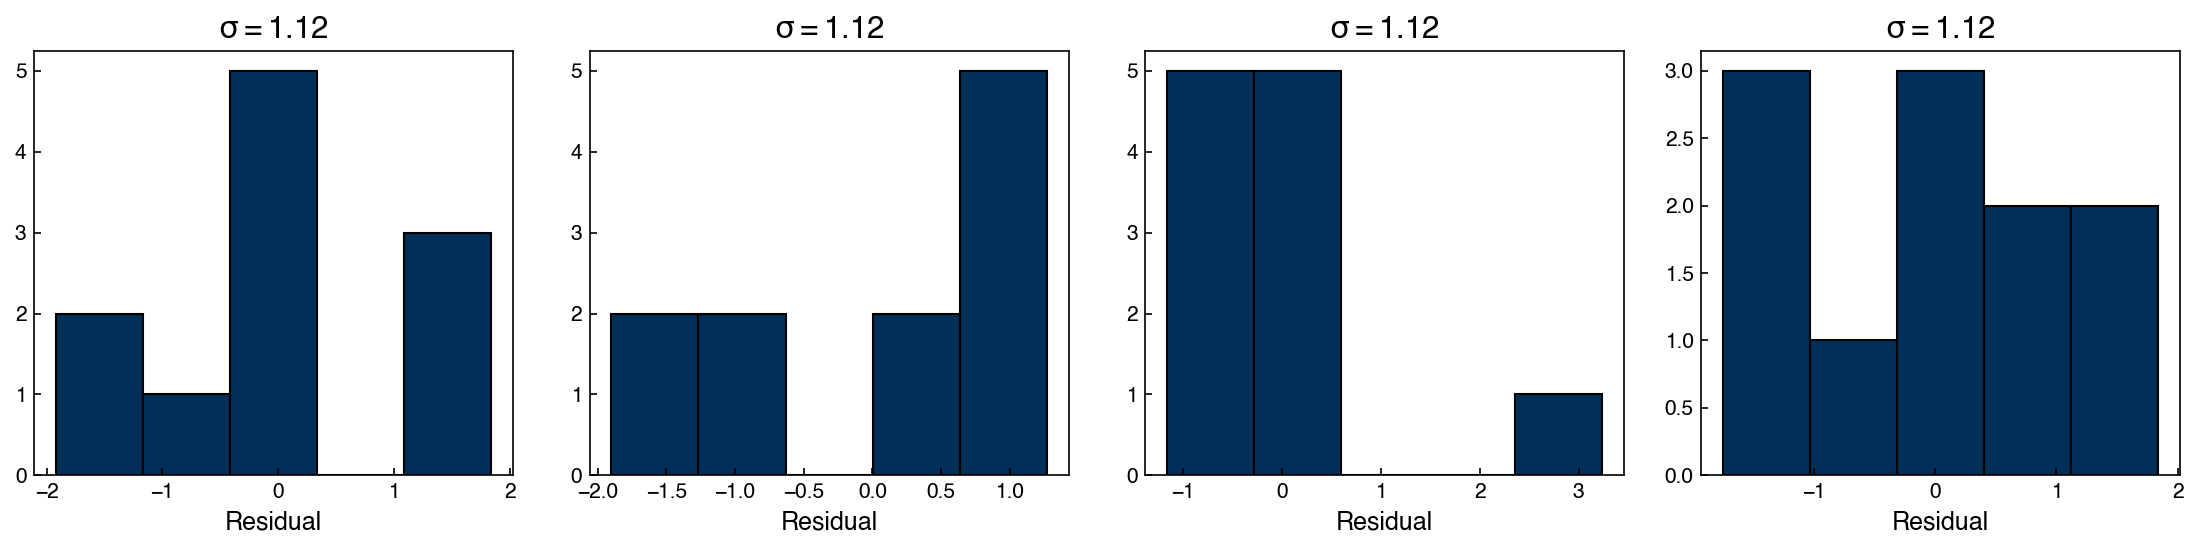

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

for ax, label, x, y in zip(axes.flatten(), labels, xs, ys):

    ax.set_title(f'Dataset {label}')

    m, b = np.polyfit(x, y, deg=1)
    yhat = m*x + b
    residuals = y - yhat
    ax.hist(residuals, bins=5, edgecolor='k')
    ax.set_xlabel('Residual')
    ax.set_title(f'$\sigma = {residuals.std():.2f}$')

plt.tight_layout();

A *roughly Gaussian* residual histogram centered at zero indicates that errors are random and homoscedastic, supporting the use of aggregate metrics such as RMSE.  Skewed or heavy‑tailed residuals (as seen for Dataset IV) warn that single‑number metrics can hide important structure in the errors.


```{admonition} Exercise
:class: tip
Compute the MAE, RMSE, and maximum error for each dataset III in Anscomb's quartet with and without the outlier, and determine which metric is most sensitive to the outlier.
```

## Cross Validation

In the prior examples we computed error metrics for models that were trained with **all** available data.  However, what we really care about is *generalization*—how the model will perform on **new** data.  Gathering additional measurements is often impractical, so we **simulate** this situation through **cross‑validation**.  In cross‑validation some examples (the *test* set) are hidden while the model is fit to the remaining *training* examples; we then evaluate the loss on the hidden data to see how well the model predicts it.

There are many standard strategies:

- **hold‑out** – randomly leave out a percentage (commonly ≈30 %) of the data during training.
- **k‑fold** – split the data into *k* (typically 3–5) random, equally‑sized groups and train *k* times, holding each group out once.
- **leave‑p‑out** – leave *p* (often 1) samples out, evaluate the error on those *p* samples, and repeat for every possible size‑*p* subset.
- **bootstrapping** – sample with replacement to generate synthetic datasets of the same size, repeating many times.

Different techniques balance statistical robustness and computational effort.  Hold‑out is fast but can be sensitive to unlucky splits, especially for small datasets.  k‑fold alleviates that risk at the cost of *k* model fits.  Leave‑*p*‑out becomes expensive for *p > 1*.  **Doing some form of cross‑validation is almost always better than none.**

```{admonition}
:class: note
All cross‑validation techniques rely on the critical assumption that *the collected data are representative of future data*.  An example in chemical engineering would be building a model at one set of process conditions but then applying it under very different conditions. The CV accuracy will look deceptively good in that case, and the model will perform much worse when applied to the new conditions.
```

In this section, we will return to the ethanol IR spectrum dataset and demonstrate various types of cross validation.

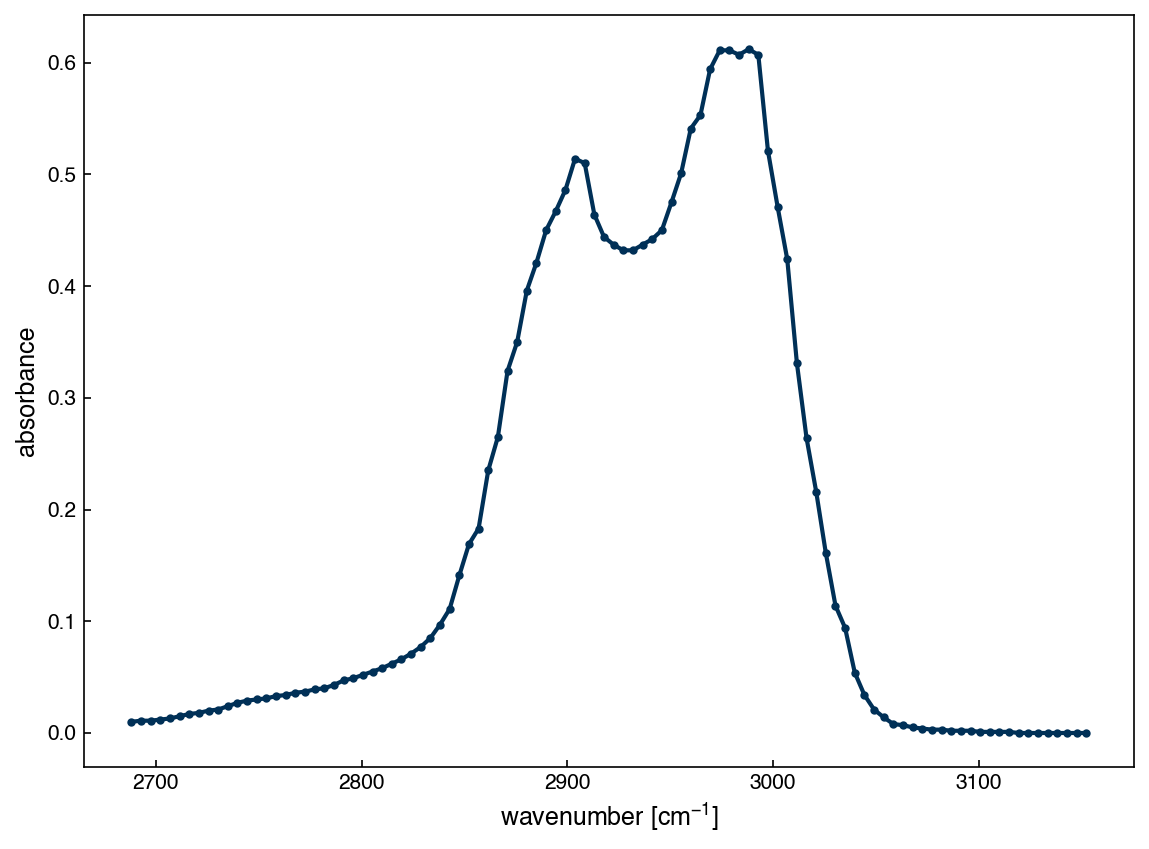

In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load data and extract the main peak region

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '-', marker='.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

### Hold‑out cross validation

Hold-out cross validation is the simplest form, where you simply hide some subset of the data from the training. There are various ways of selecting which data to hold out, and different strategies will affect how the technique performs.

#### Deterministic every‑third‑point split

A quick deterministic variant of hold‑out is to **train on every Nth point** and test on the full dataset. This approach makes sense if you are trying to build a model that is capable of interpolating between known data, such as a model for replacing missing values. It is rarely used in practice, but is a useful conceptual demonstration.

r^2 training = 1.000
r^2 all data  = 0.998


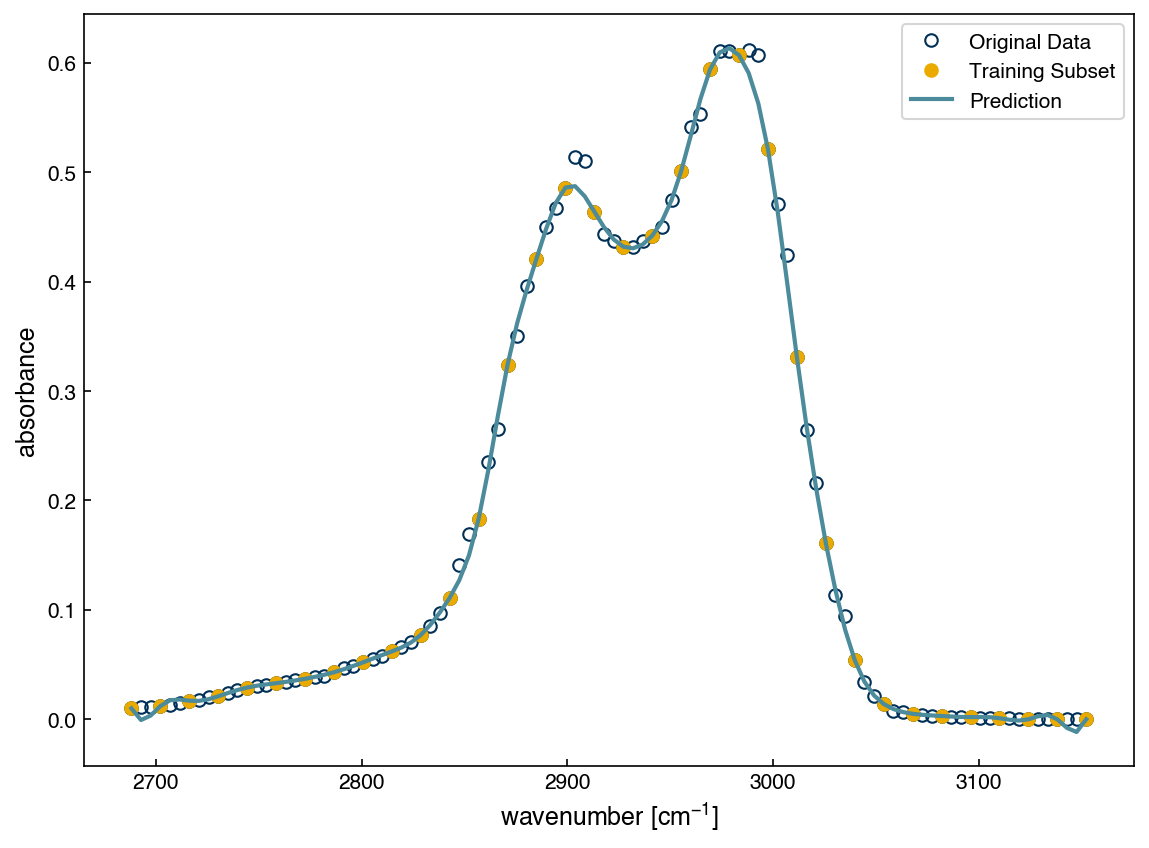

In [7]:
spacing = 3
sigma = 10
gamma = 1.0 / (2 * sigma ** 2)

x_train = x_peak[::spacing]
y_train = y_peak[::spacing]

# Radial basis function helper
def rbf(x_train, x_test=None, *, gamma=1.0):
    if x_test is None:
        x_test = x_train
    N, M = len(x_test), len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = np.exp(-gamma * (x_test[i] - x_train[j]) ** 2)
    return X

X_train = rbf(x_train, gamma=gamma)
model_rbf = LinearRegression().fit(X_train, y_train)
print(f"r^2 training = {model_rbf.score(X_train, y_train):.3f}")

X_all = rbf(x_train, x_test=x_peak, gamma=gamma)
print(f"r^2 all data  = {model_rbf.score(X_all, y_peak):.3f}")

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'o', markerfacecolor='none')
ax.plot(x_train, y_train, 'o')
ax.plot(x_peak, model_rbf.predict(X_all), '-')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.legend(['Original Data', 'Training Subset', 'Prediction']);

This is a kind of hold‑out because the model has never seen two‑thirds of the points.  The pattern in the residuals hints that our kernel width, $\sigma\$, may be sub‑optimal.

#### Random 60 / 40 split with `train_test_split`

Random splits avoid the structure of the deterministic split but introduce sampling variability.  By fixing `np.random.seed(0)` the split—and therefore the output—will be reproducible each time this cell is run. Random splits are more commonly used in practice, with 20-40% of the data typically being held out.

r^2 training = 1.000
r^2 testing  = 0.874
r^2 all data  = 0.949


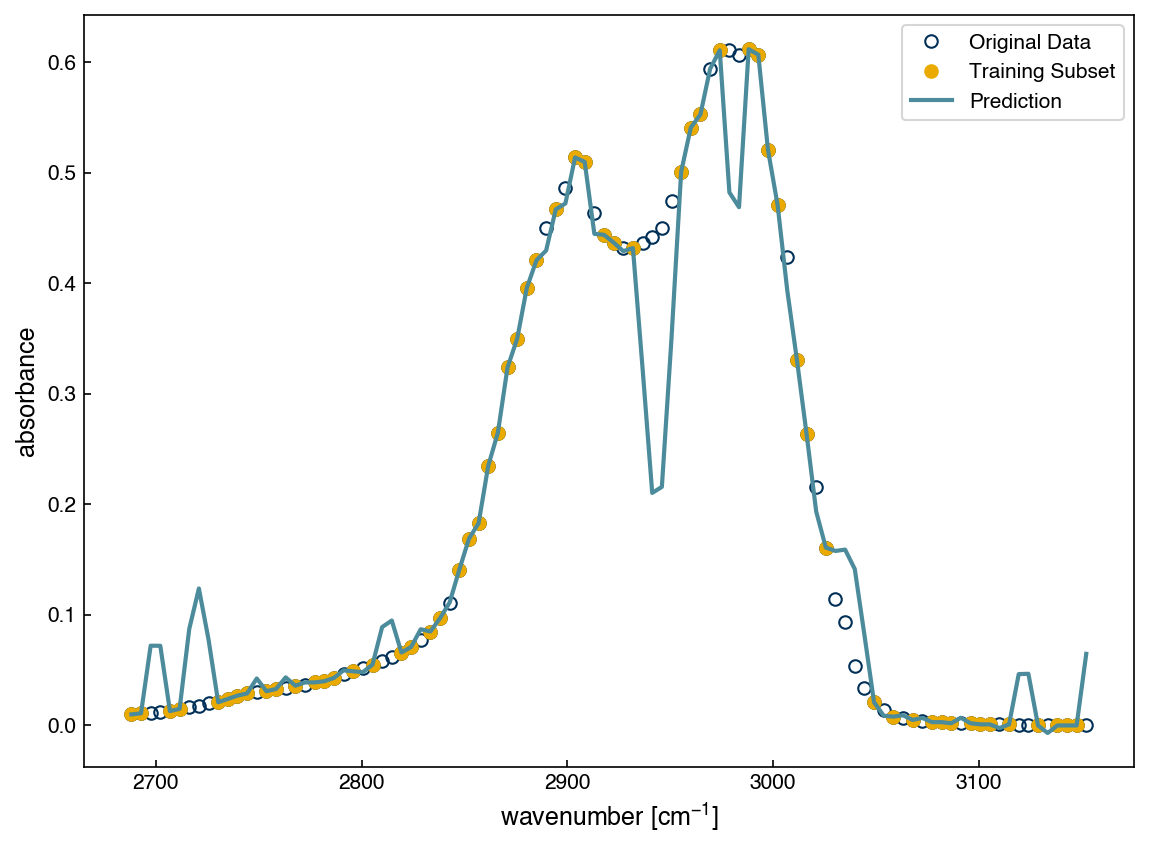

In [8]:
from sklearn.model_selection import train_test_split
np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.4)

sigma = 5
gamma = 1.0 / (2 * sigma ** 2)

X_train = rbf(x_train, gamma=gamma)
model_rbf = LinearRegression().fit(X_train, y_train)
print(f"r^2 training = {model_rbf.score(X_train, y_train):.3f}")

X_test = rbf(x_train, x_test=x_test, gamma=gamma)
print(f"r^2 testing  = {model_rbf.score(X_test, y_test):.3f}")

X_all = rbf(x_train, x_test=x_peak, gamma=gamma)
print(f"r^2 all data  = {model_rbf.score(X_all, y_peak):.3f}")


fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'o', markerfacecolor='none')
ax.plot(x_train, y_train, 'o')
ax.plot(x_peak, model_rbf.predict(X_all), '-')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.legend(['Original Data', 'Training Subset', 'Prediction']);

We see that the model performs very poorly on the testing data if `sigma` is not chosen well. We can also visualize this with a parity plot:

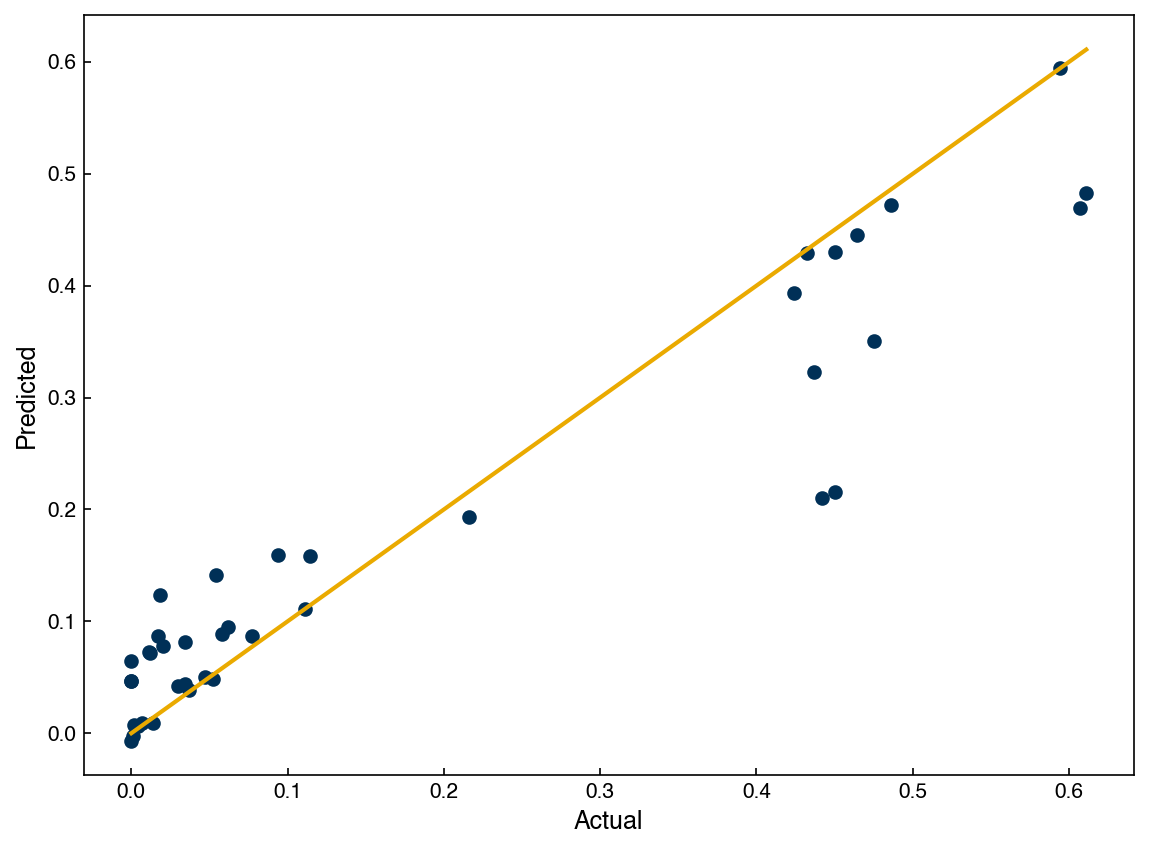

In [9]:
fig, ax = plt.subplots()
ax.plot(y_test, model_rbf.predict(rbf(x_train, x_test=x_test, gamma=gamma)), 'o')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted');

### k‑fold Cross Validation

Hold‑out yields **one** estimate of test error; **k‑fold** repeats the procedure *k* times for more robust statistics. This reduces the chances that our results are based on a specific sample, but increases the computational cost.

mean r^2 (test) = 0.996 ± 0.002


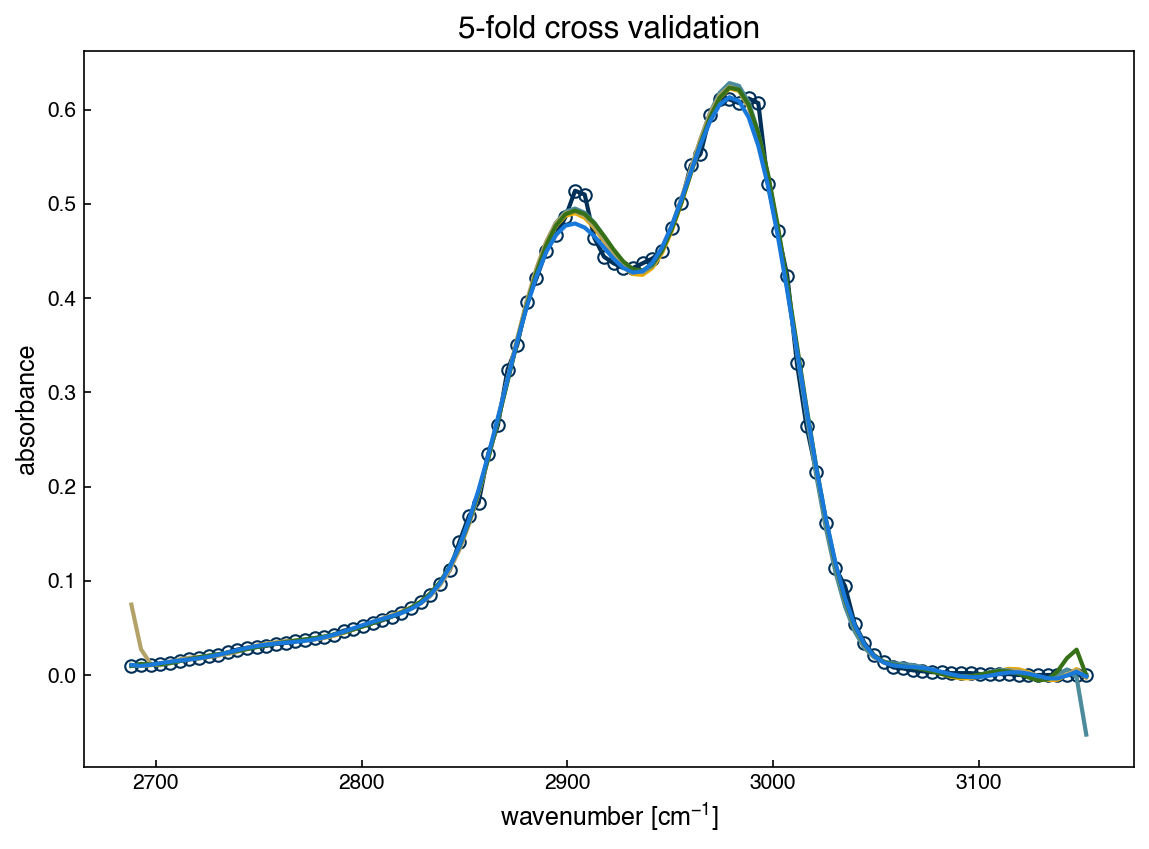

In [10]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)
sigma = 100
gamma = 1.0 / (2 * sigma ** 2)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '-o', markerfacecolor='none')

r2_test = []
for train_idx, test_idx in kf.split(x_peak):
    x_tr, x_te = x_peak[train_idx], x_peak[test_idx]
    y_tr, y_te = y_peak[train_idx], y_peak[test_idx]

    X_train = rbf(x_tr, gamma=gamma)
    X_test = rbf(x_tr, x_test=x_te, gamma=gamma)
    X_all = rbf(x_tr, x_test=x_peak, gamma=gamma)

    model = LinearRegression().fit(X_train, y_tr)

    r2 = model.score(X_test, y_te)
    r2_test.append(r2)
    y_all = model.predict(X_all)

    ax.plot(x_peak,y_all,  '-')

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.set_title(f'{kf.n_splits}-fold cross validation');
print(f"mean r^2 (test) = {np.mean(r2_test):.3f} ± {np.std(r2_test):.3f}")

When the end‑points land in the test fold, the model must **extrapolate** and often fails catastrophically.  k‑fold CV lowers the risk of an **overly lucky** (or unlucky) split—but at the computational cost of *k* separate model fits.

```{admonition} Exercise
:class: note

In the code block above, note that we used `shuffle=True` when performing k-fold cross validation. This ensures that the data is shuffled before the folds are taken, so that each fold is effectively random rather than sequential. 

Re-make the plot with `shuffle=False` and visualize the result. Compare the MAE of each fold, and consider whether this is a meaningful way to do cross validation for this dataset.
```

### Leave‑One‑Out Cross Validation (LOO)

Leave‑one‑out is the limiting case of *k*-fold cross validation with *k = N* (the number of observations): each iteration trains on *N − 1* points and tests on the single left‑out point.  It provides an almost unbiased estimate of generalization error but can be computationally intensive for large datasets.

In [11]:
from sklearn.model_selection import LeaveOneOut

X = np.asarray(x_peak).reshape(-1, 1)
y = np.asarray(y_peak).ravel()

sigma = 10.0
gamma = 1.0 / (2.0 * sigma**2)

Xrbf = rbf(x_peak, gamma=gamma)
model = LinearRegression().fit(Xrbf, y)
y_hat = model.predict(Xrbf).ravel()

loo = LeaveOneOut()
rmse_loo = []

for tr_idx, te_idx in loo.split(X):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    Xrbf_tr = rbf(X_tr.ravel(), gamma=gamma)
    Xrbf_te = rbf(X_tr.ravel(), x_test=X_te.ravel(), gamma=gamma)

    model = LinearRegression().fit(Xrbf_tr, y_tr)
    y_hat = model.predict(Xrbf_te) 
    rmse_loo.append(root_mean_squared_error([y_te], y_hat))

print(f"mean RMSE (LOO) = {np.mean(rmse_loo):.3e}")
print(f"std  RMSE (LOO) = {np.std(rmse_loo):.3e}")

mean RMSE (LOO) = 7.807e-02
std  RMSE (LOO) = 3.727e-01


Note that since we compute the metric on a single data point, we need to use something like RMSE or MAE rather than $r^2$, since $r^2$ is not defined for a single point.

Because each LOO model is trained on nearly the entire dataset, the variation in the models and predictions will be low.  However, the variation of the **error estimate** can be high: a single anomalous observation can strongly influence one iteration’s score.  Computationally, LOO requires *N* model fits, which is feasible for small‑to‑medium data but prohibitive for very large datasets.

```{admonition}
:class: tip
**Task**  
Investigate how the **test‑set fraction** influences the stability of performance estimates for the RBF model at $\sigma = 10$.

1. Choose three fractions: 20 %, 30 %, and 40 %.
2. For each fraction, perform at least **100** random splits with `train_test_split` (set `random_state=None` inside the loop).
3. Compute the test‑set $r^2$ for every split.
4. Visualize the resulting distributions (boxplots or histograms) side‑by‑side.

Which fraction yields the *lowest variance* in $r^2$?  Explain why smaller or larger test fractions may lead to more or less stable estimates.
```

## Quantifying Error and Uncertainty

In addition to model accuracy, it is often useful to have an estimate of *uncertainty*: a range that brackets the predictions we expect from future data.  We will go back to Anscombe’s quartet to illustrate these ideas.

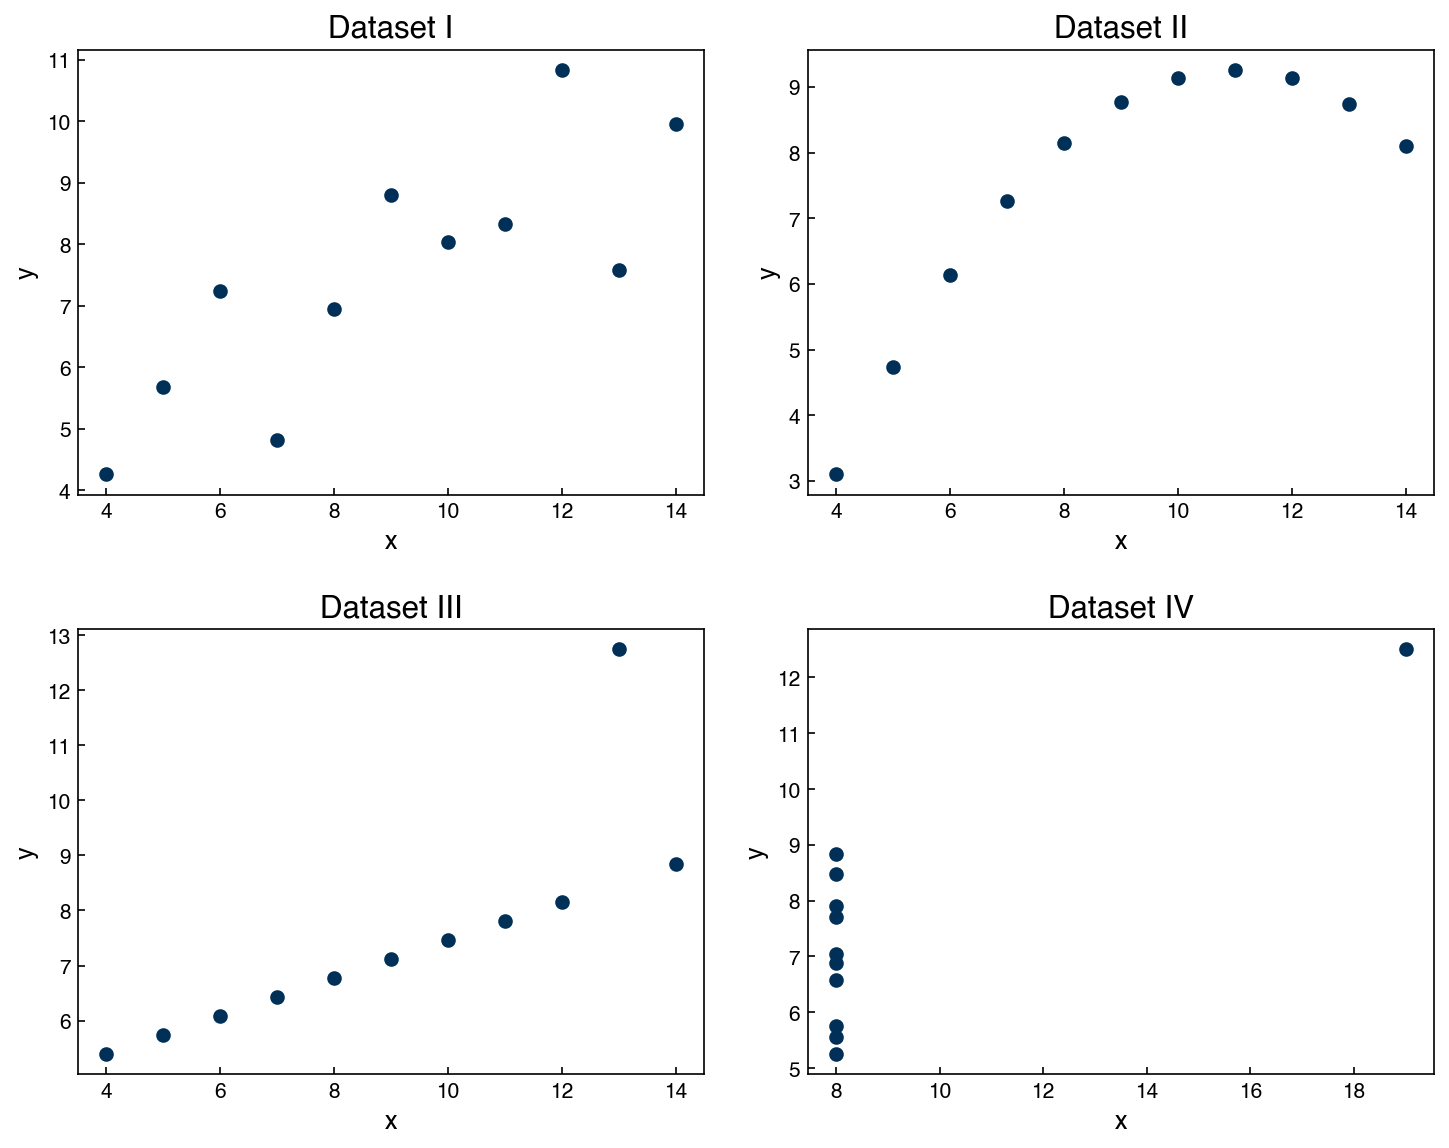

In [12]:
import matplotlib.pyplot as plt

# Restore Anscombe's quartet variables
xs = [x1, x2, x3, x4]
ys = [y1, y2, y3, y4]
labels = ['I', 'II', 'III', 'IV']

# Re-generate scatterplot for each dataset
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, label, x, y in zip(axes.flatten(), labels, xs, ys):
    ax.scatter(x, y)
    ax.set_title(f'Dataset {label}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.tight_layout()

### Standard Deviation of Error


One simple way of quantifying uncertainty is to assess the standard deviation of the *residuals* (model errors):

In [13]:
m, b = np.polyfit(x1, y1, 1)
yhat = m*x1 + b
error_stdev = np.std(y1 - yhat, ddof=2)
print(error_stdev)

1.236603322726321


Note that we used `ddof=2` here, since we have 2 degrees of freedom removed due to the 2 parameters in the model. This doesn't really matter if you have very large datasets, but since these datasets are small (only 11 points) we need to account for it. Also note that the standard deviation is the same for each dataset in Anscomb's quartet.

We can use the following expression to account for how the uncertainty changes as a function of $x$:

$\vec{\sigma_y} = \sigma_{error} \sqrt{\left(1 + \frac{1}{n} + \frac{(\vec{x}-\bar{x})^2}{(\sum_j x_j - \bar{x})^2} \right)}$

where $\sigma_{error}$ is the standard deviation of the error.

However, this is only valid under the case that all assumptions of linear regression hold:

* Error is normally distributed
* Error is homoscedastic
* The relationship between the variables is linear

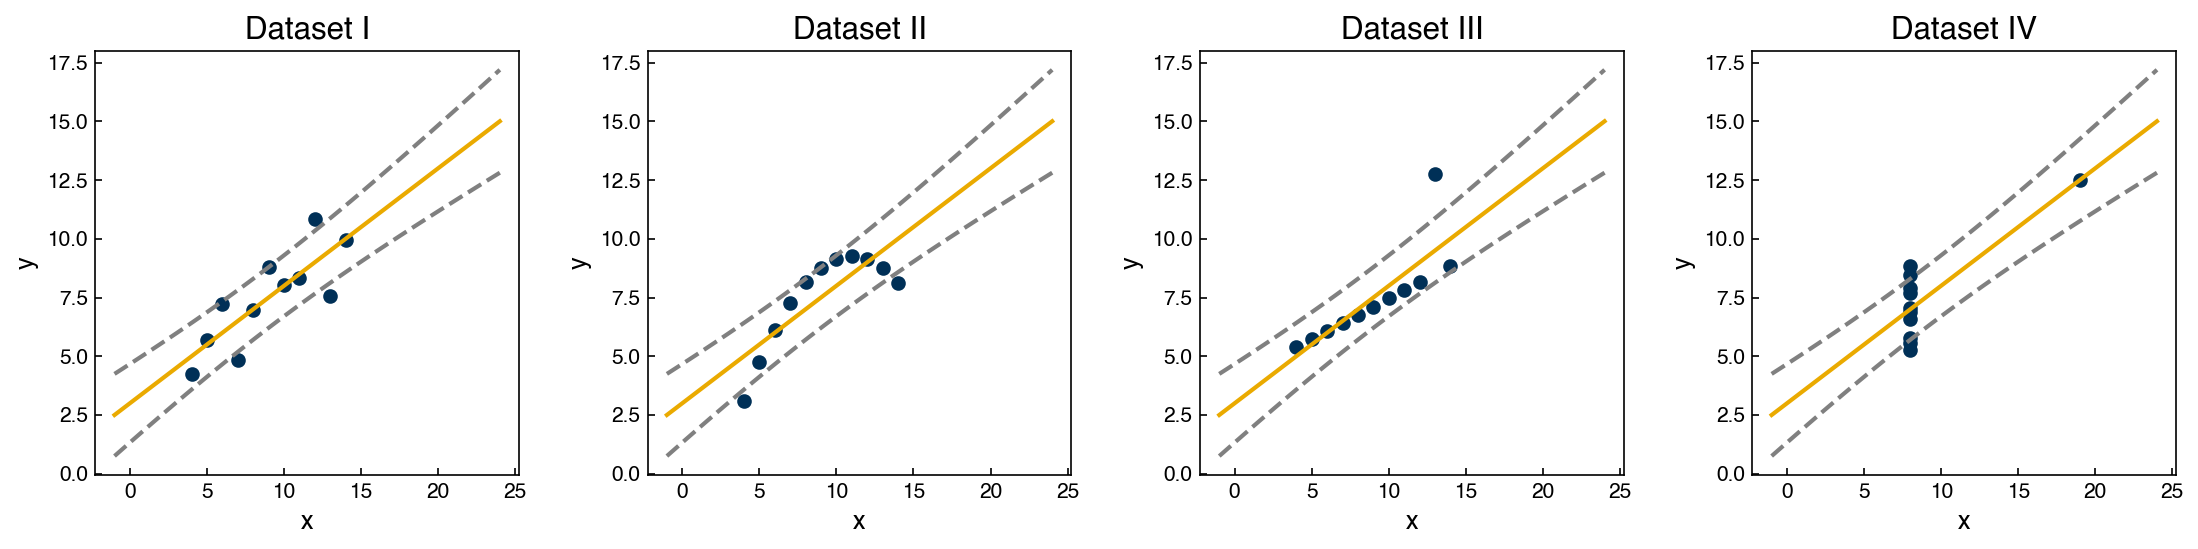

In [14]:
def regression_error(x,y, x_data, yhat):
    sigma_error = np.std(y-yhat, ddof=2)
    xbar = np.mean(x_data)
    y_error = sigma_error * np.sqrt(1 + 1/len(y) + ((x-xbar)**2)/(np.sum((x_data-xbar)**2)))
    return y_error

x_dense = np.linspace(min(x1) - 5, max(x4) + 5, 50)

y_error = regression_error(x_dense, y1, x1, m * x1 + b)

fig, axes = plt.subplots(1, 4, figsize = (15, 4))

for ax, label, x, y in zip(axes.flatten(), labels, xs, ys):
    ax.plot(x, y, 'o')
    ax.plot(x_dense, m*x_dense+b)
    ax.plot(x_dense, m*x_dense+b + y_error, ls = '--', color = '0.5')
    ax.plot(x_dense, m*x_dense+b - y_error, ls = '--', color = '0.5')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Dataset {label}')


These $\pm1\,\sigma$ bands assume *homoskedastic*, Gaussian errors.  They clearly miss the outlier in Dataset IV, showing that identical error bars do **not** suit every dataset.


```{admonition} Are these error bounds applicable to all datasets in Anscomb's quartet?
:class: note
No.  The underlying error structure varies across the quartet. Datasets III and IV, in particular, contain a large outliers, so constant-width error bands are inappropriate for these datasets. Only dataset I appears to approximately follow the homoskedastic Gaussian error assumption.
```

### Resampling or "bootstrapping"

Another possibility that avoids homoskedastic assumptions is to **resample** the data to build empirical distributions of parameters that capture the deviations in the data.  A simple approach is to **sample with replacement** so that each re‑sample is slightly different. This is referred to as "bootstrapping".

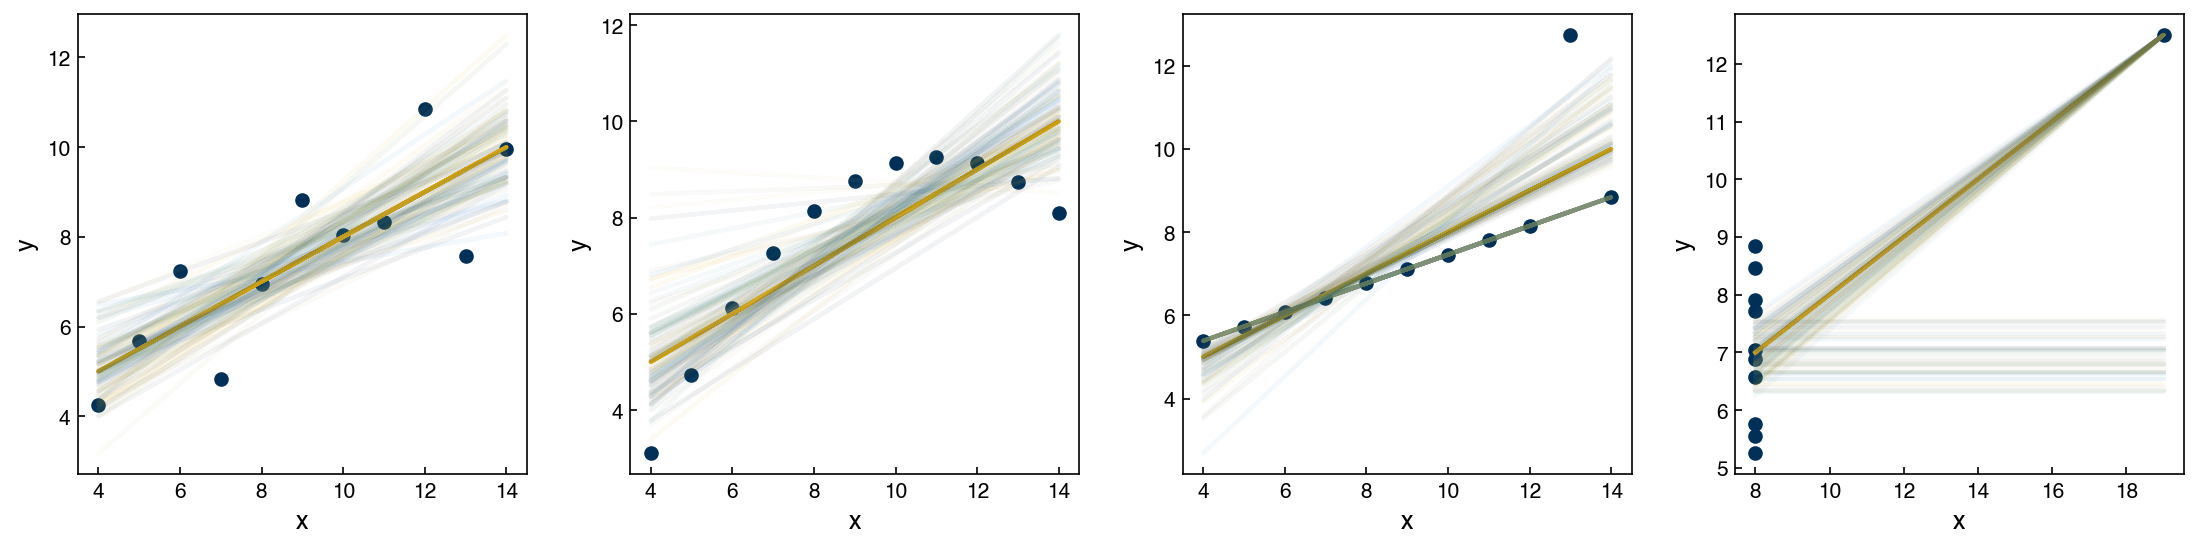

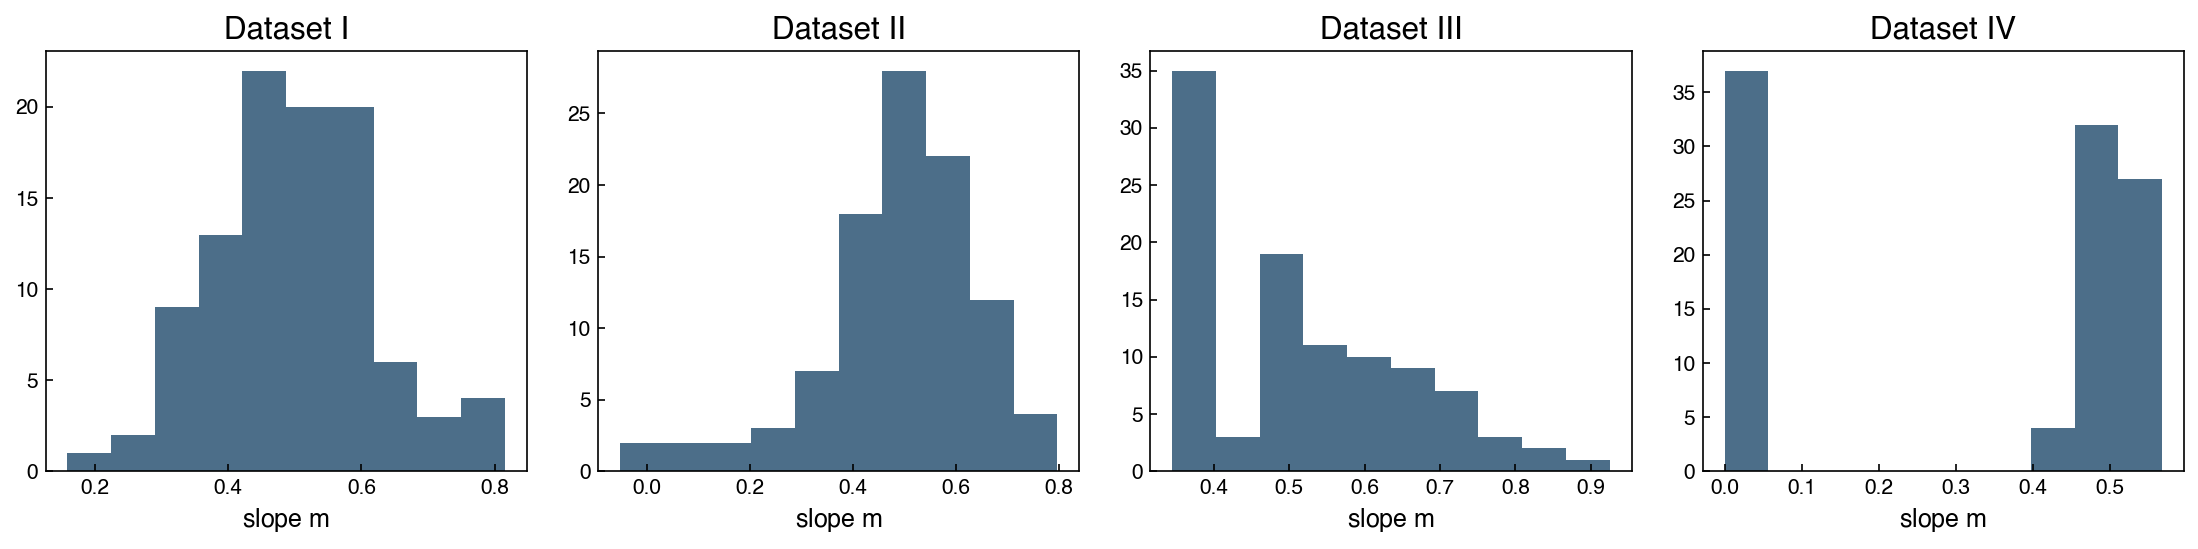

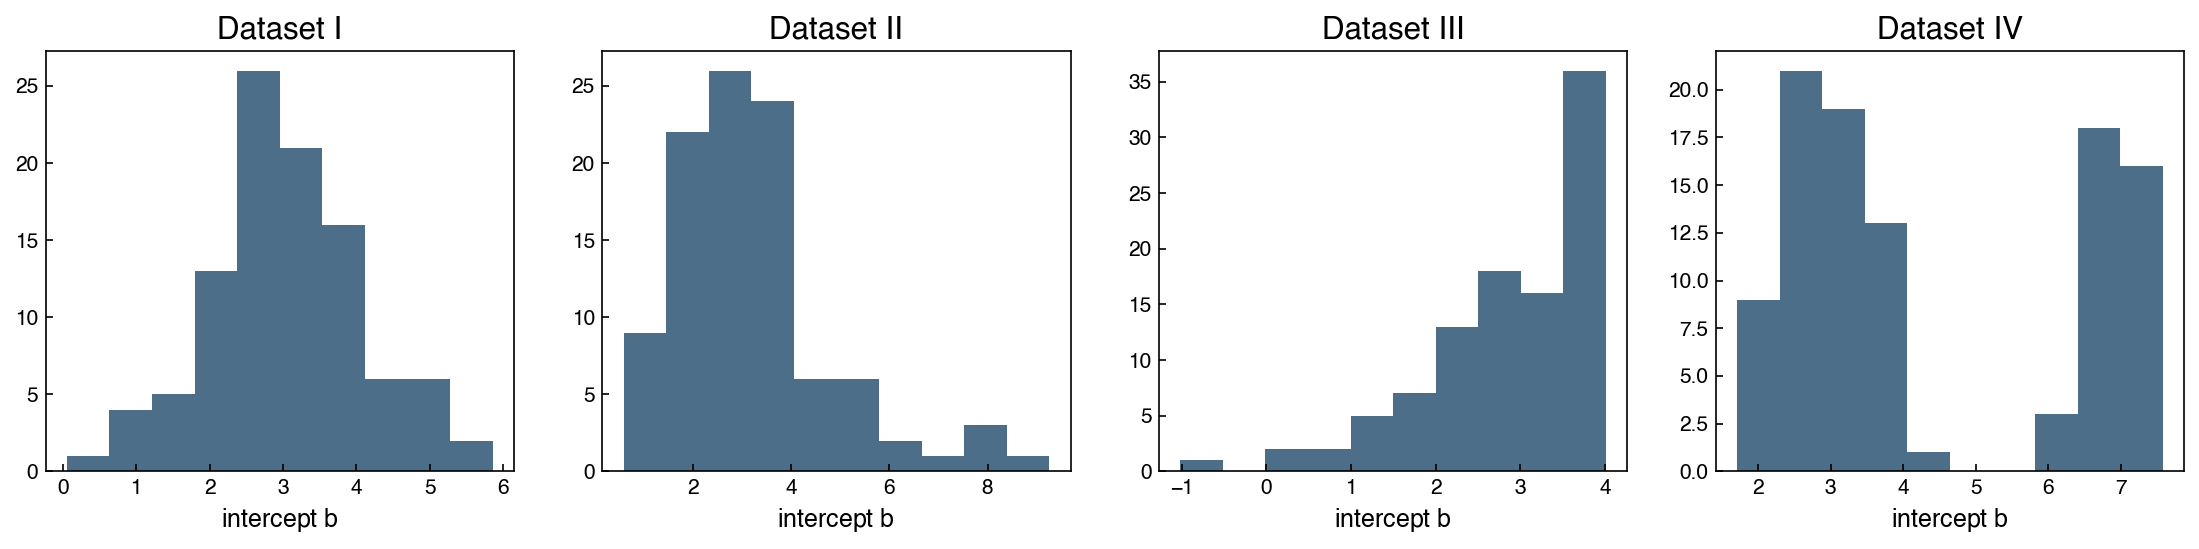

In [15]:
from numpy.random import choice  # randomly select items from a list

def bootstrap_linregress(x_all, y_all, N):
    m_list, b_list = [], []
    for _ in range(N):
        subset = choice(range(len(x_all)), size=len(x_all), replace=True)
        xprime = [x_all[j] for j in subset]
        yprime = [y_all[j] for j in subset]
        if np.std(xprime) > 0:
            m, b = np.polyfit(xprime, yprime, deg=1)
        else:
            m = 0
            b = np.mean(yprime)
        m_list.append(m)
        b_list.append(b)
    return m_list, b_list


fig, axes = plt.subplots(1, 4, figsize=(15, 4))
fig_m, axes_m = plt.subplots(1, 4, figsize = (15, 4))
fig_b, axes_b = plt.subplots(1, 4, figsize = (15, 4))
N = 100

for ax, ax_m, ax_b, label, x, y in zip(axes.flatten(), axes_m.flatten(), axes_b.flatten(), labels, xs, ys):

    m, b = np.polyfit(x, y, deg=1)
    m_list, b_list = bootstrap_linregress(x, y, N)
    ax.plot(x, y, 'o')
    ax.plot(x, m*x+b, lw=2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax_m.set_title(f'Dataset {label}')

    #plot distributions of slope
    ax_m.hist(m_list, bins=10, alpha=0.7)
    ax_m.set_xlabel('slope $m$')
    ax_m.set_title(f'Dataset {label}')

    #plot distributions of intercept
    ax_b.hist(b_list, bins=10, alpha=0.7)
    ax_b.set_xlabel('intercept $b$')
    ax_b.set_title(f'Dataset {label}')

    #plot individual models
    for mj, bj in zip(m_list, b_list):
        ax.plot(x, mj*x + bj, alpha = 0.05)

You don't need to understand all the details of this code block, but should understand the general idea. Re-sampling is closely related to cross-validation. We hide some of the data from the model and see how the model changes. The difference is that we keep the **models**, rather than just analyzing the errors. Then we can use the models to give a range of estimates, or check the parameters of the models to see how much parameters change depending on the data.


This approach is very powerful because it allows us to get estimates of the prediction error as well as the error distribution of the parameters. In principle, any sort of re-sampling can be used to generate model ensembles, although the statistical rigor of the resulting error estimates will vary depending on the assumptions. However, many types of uncertainty quantification approaces, even for large neural network models, are based on some similar ideas of "ensembles" of models that are trained under varying datasets or assumptions.

### Gaussian Process Regression

Gaussian process regression (GPR) is an extension of kernel methods that provides a *probabilistic* prediction complete with uncertainty.  A full treatment is beyond our scope, but we will briefly demonstrate it for the ethanol‑spectrum dataset:

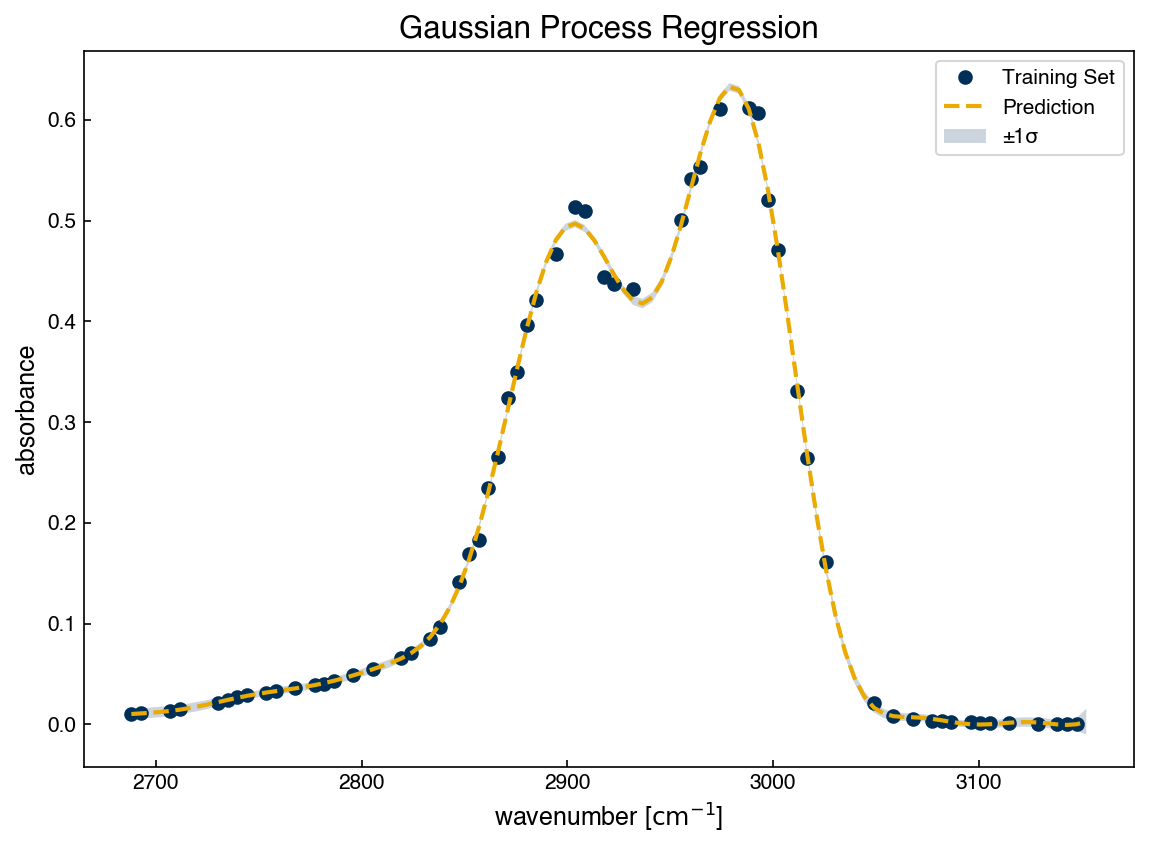

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x_peak = x_peak.reshape(-1, 1)
y_peak = y_peak.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.4, random_state=0)

gpr = GaussianProcessRegressor(kernel=RBF(length_scale=10.0), alpha=5e-5, random_state=0)
gpr.fit(x_train, y_train)

y_gpr, y_std = gpr.predict(x_peak, return_std=True)  # both 1-D: (n_samples,)
xp = x_peak.ravel()

fig, ax = plt.subplots()
ax.plot(x_train[:, 0], y_train[:,0], 'o', label='Training Set')
ax.plot(xp, y_gpr, '--', label='Prediction')
ax.fill_between(xp, y_gpr - y_std, y_gpr + y_std, alpha=0.2, label='±1σ')
ax.set_xlabel(r'wavenumber [$\mathrm{cm^{-1}}$]')
ax.set_ylabel('absorbance')
ax.legend()
ax.set_title('Gaussian Process Regression');

GPR is powerful for uncertainty estimation because it treats the unknown function as a "prior Gaussian process". We assume any finite collection of function values follows a multivariate normal distribution whose *covariance* is governed by a "kernel".  The kernel encodes assumptions about smoothness, periodicity, and overall variation. GPR is very similar to kernel ridge regression, and is identical in some limits, but in general the results can differ. A few things to consider when working with GPR:

- **Kernel selection** — Common kernels are the same as for kernel ridge regression, and include the squared‑exponential (RBF), Matérn, and periodic forms; sums or products of kernels can model more complex structure.  Choosing an inappropriate kernel can over‑smooth the data or yield wildly uncertain predictions.
- **Hyper‑parameter optimization** — Each kernel carries hyper‑parameters (e.g., length‑scale, variance).  Scikit‑learn maximizes the log‑marginal likelihood by default, but you can also tune hyper‑parameters via cross‑validation or Bayesian optimization.  Good uncertainty estimates depend critically on finding well‑calibrated values.
- **Computation** — Exact GPR scales as \$\mathcal{O}(N^3)\$ due to matrix inversion, so large datasets may require sparse approximations or inducing‑point methods.

For a candid discussion of the strengths and pitfalls of Bayesian model selection, especially Gaussian processes, see the blog post [“Lies, damn lies, statistics, and **Bayesian** statistics”](https://kitchingroup.cheme.cmu.edu/blog/2025/06/22/Lies-damn-lies-statistics-and-Bayesian-statistics/). The post is actually written by a chemical engineer (Prof. John Kitchin), and uses an example that is relevant to chemical engineers who work with atomic-scale models.

```{admonition}
:class: tip
Use the **bootstrap_linregress** function with **$N = 500$** re‑samples on **Dataset 2** of Anscombe’s quartet.  Plot histograms of the bootstrapped slopes and intercepts, and report the **95 % empirical confidence interval** for each.
```

## Additional Reading

- {cite}`hastie2009` – **The Elements of Statistical Learning**, *Ch. 3* introduces model assessment and selection.  
- {cite}`goodfellow2016` – *Deep Learning*, Chap. 7 discusses regularization and validation.  
- {cite}`bishop2006` – *Pattern Recognition and Machine Learning*, Sect. 3.3 covers Gaussian processes.  
- {cite}`efron1994` – *An Introduction to the Bootstrap* for deeper insight into resampling methods.

```{{bibliography}}
```